**Simple OLS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torch

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [3]:
seed_everything(17)

c:\Users\Root\dacon\AiSparkChallenge4th-3\.conda\lib\site-packages\torch\random.py:46: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  return default_generator.manual_seed(seed)


In [4]:
train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [5]:
train_type = train['type']
test_type = test['type']
train.drop(['type'], axis=1, inplace=True)
test.drop(['type'], axis=1, inplace=True)

In [6]:
train['out_pressure'].value_counts()

0.7    2463
Name: out_pressure, dtype: int64

In [7]:
train.drop('out_pressure', axis=1, inplace=True)
test.drop('out_pressure', axis=1, inplace=True)

<Axes: >

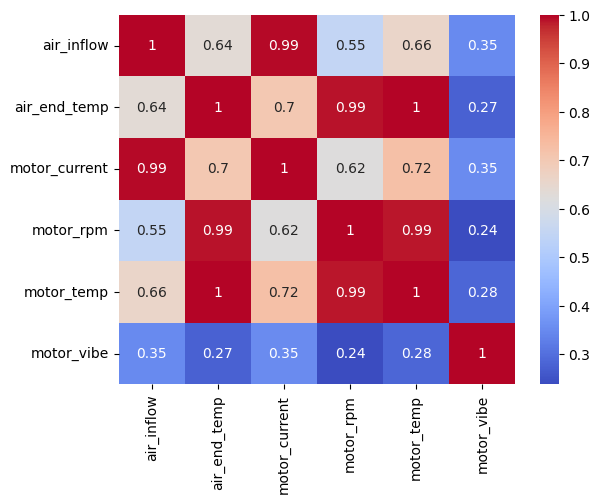

In [8]:
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)

In [11]:
train_pca = pd.DataFrame(train_pca)
train_pca.columns = train_pca.columns.astype('str')
test_pca = pd.DataFrame(test_pca)
test_pca.columns = test_pca.columns.astype('str')
train_pca['type']  = train_type
test_pca['type']  = test_type


<Axes: xlabel='0', ylabel='1'>

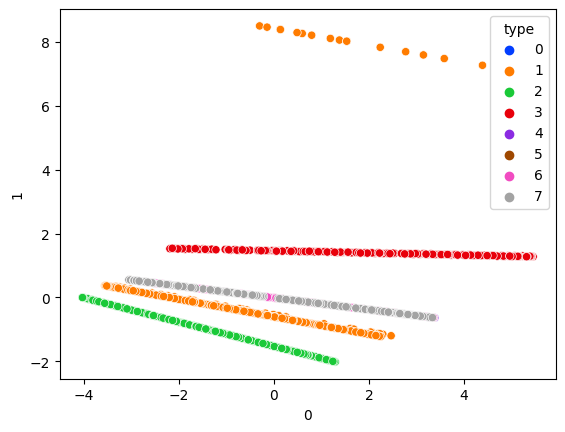

In [12]:
sns.scatterplot(data=train_pca, x='0', y='1', hue='type', palette='bright')

<Axes: xlabel='0', ylabel='1'>

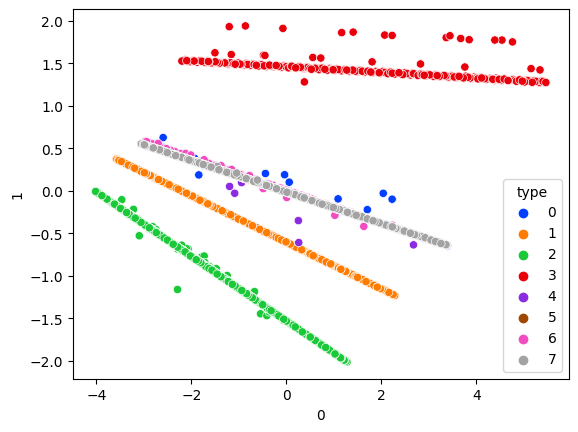

In [13]:
sns.scatterplot(data=test_pca, x='0', y='1', hue='type', palette='bright')

In [14]:
train_pca = train_pca[train_pca['1']<4]

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

df_container = [(train_pca[train_pca.type == i], test_pca[test_pca.type == i])  for i in range(8)]
residual_container = []
anomaly_container = []

for train_df, test_df in df_container:
    lr = LinearRegression()
    lr.fit(train_df[['0']], train_df['1'])
    pred = lr.predict(test_df[['0']])
    res_max = np.max(abs(train_df['1'] - lr.predict(train_df[['0']])))
    residual = abs(test_df['1'] - pred)
    residual_container.append(residual)
    is_anomaly = (residual > res_max).astype(int)
    anomaly_container.append(is_anomaly)

In [16]:
residual_df = pd.concat(residual_container)
anomaly_df = pd.concat(anomaly_container)

In [17]:
# outlier_percentage = 0.02
# error_threshold = np.percentile(residual, 100*(1-outlier_percentage)+0.01)
# is_anomaly = residual > error_threshold

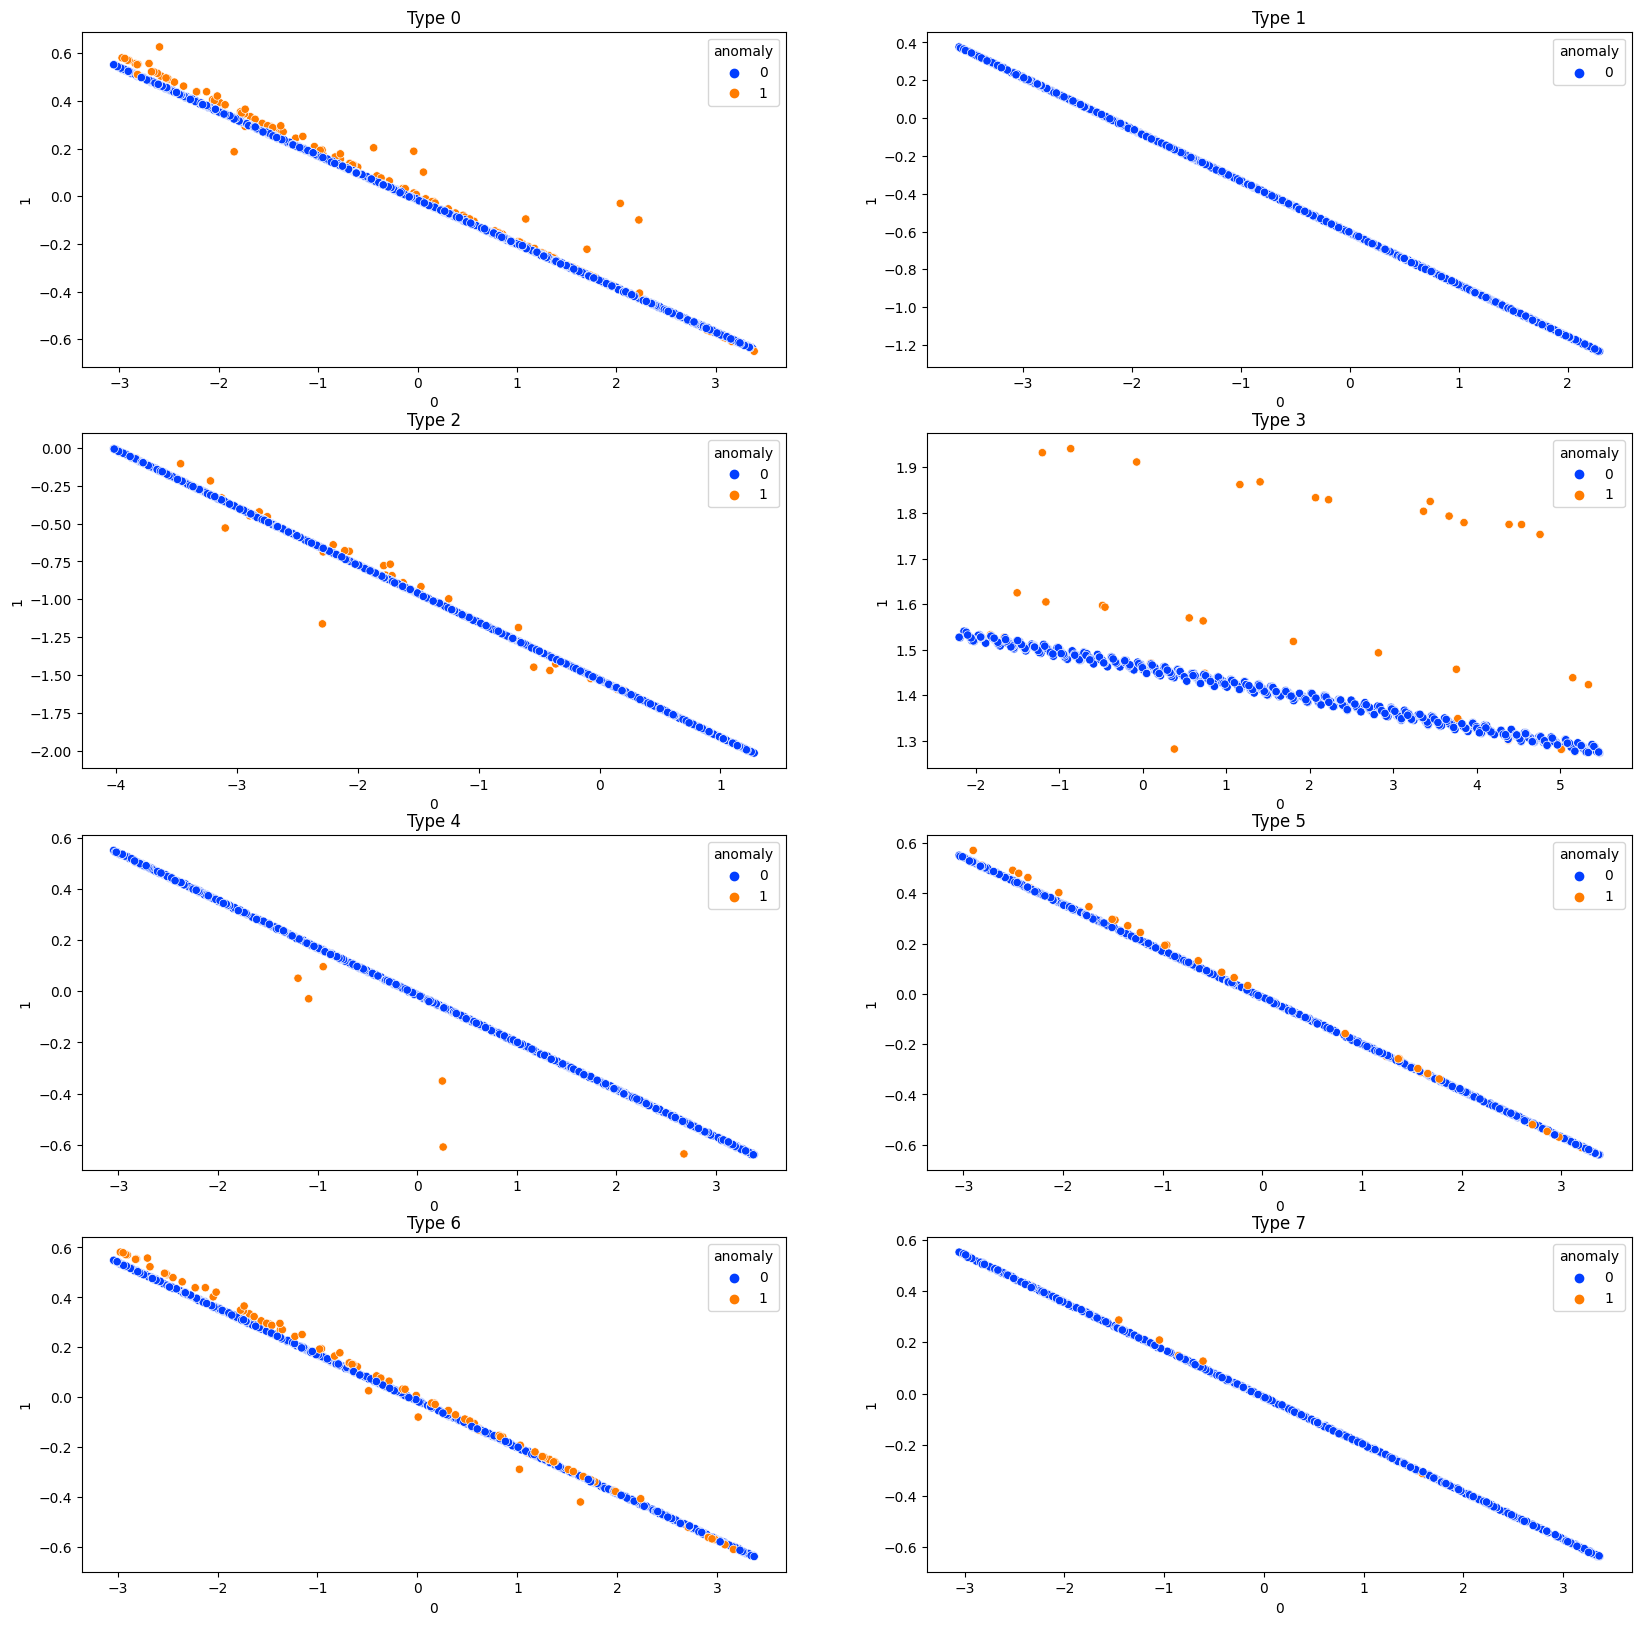

In [18]:
test_pca['anomaly'] = anomaly_df
fig = plt.figure(figsize=(20,20))
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    ax.set_title(f"Type {i}")
    sns.scatterplot(data=test_pca[test_pca.type==i], x='0', y='1', hue='anomaly', palette='bright')

In [19]:
sub = pd.read_csv("../data/answer_sample.csv")
sub['label'] = anomaly_df

In [20]:
sub.to_csv("../results/ols_submission_1.csv", index=False)

In [21]:
sub['label'].value_counts()

0    7059
1     330
Name: label, dtype: int64